# Monte Carlo Methods

In this notebook, you will write your own implementations of many Monte Carlo (MC) algorithms. 

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

### Part 0: Explore BlackjackEnv

We begin by importing the necessary packages.

In [2]:
import sys
import gym
import gym.spaces
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

In [81]:
import logging
logging.basicConfig(stream=sys.stderr, level=logging.DEBUG)
logger_1 = logging.getLogger('logger_1')
logger_1.propagate = False
logger_2 = logging.getLogger('logger_2')
logger_2.propagate = False
logger_3 = logging.getLogger('logger_3')
logger_3.propagate = False

Use the code cell below to create an instance of the [Blackjack](https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py) environment.

In [4]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [5]:
# state, done, reward = (env.observation_space)  # unpack
print(env.action_space)  # <class 'gym.spaces.discrete.Discrete'>
print(env.observation_space)  # <class 'gym.spaces.tuple_space.Tuple'>

print(env.action_space.n)
print((env.observation_space.spaces)[0].n)

# generate all possible states
for s0 in range((env.observation_space.spaces)[0].n):  # player's current sum
    for s1 in range((env.observation_space.spaces)[1].n):  # dealer's showing card
        for s2 in range((env.observation_space.spaces)[2].n):  # usable ace
            state = (s0, s1, s2)                

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))
2
32


Execute the code cell below to play Blackjack with a random policy.  

(_The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to get some experience with the output that is returned as the agent interacts with the environment._)

In [6]:
# sample method to generate random policy
for i_episode in range(3):
    state = env.reset()
    while True:
        logger_1.info('state = {}'.format(state))
        action = env.action_space.sample()
        state, reward, done, info = env.step(action)
        if done:
            print('End game! Reward: ', reward)
            print('You won :)\n') if reward > 0 else print('You lost :(\n')
            break

End game! Reward:  -1.0
You lost :(

End game! Reward:  -1
You lost :(

End game! Reward:  1.0
You won :)



### Part 1: MC Prediction

In this section, you will write your own implementation of MC prediction (for estimating the action-value function).  

We will begin by investigating a policy where the player _almost_ always sticks if the sum of her cards exceeds 18.  In particular, she selects action `STICK` with 80% probability if the sum is greater than 18; and, if the sum is 18 or below, she selects action `HIT` with 80% probability.  The function `generate_episode_from_limit_stochastic` samples an episode using this policy. 

The function accepts as **input**:
- `bj_env`: This is an instance of OpenAI Gym's Blackjack environment.

It returns as **output**:
- `episode`: This is a list of (state, action, reward) tuples (of tuples) and corresponds to $(S_0, A_0, R_1, \ldots, S_{T-1}, A_{T-1}, R_{T})$, where $T$ is the final time step.  In particular, `episode[i]` returns $(S_i, A_i, R_{i+1})$, and `episode[i][0]`, `episode[i][1]`, and `episode[i][2]` return $S_i$, $A_i$, and $R_{i+1}$, respectively.

In [7]:
# Definition of the policy
def generate_episode_from_limit_stochastic(bj_env):
    episode = []
    state = bj_env.reset()
    logger_1.info('init_state = {}'.format(state))
    while True:
        probs = [0.8, 0.2] if state[0] > 18 else [0.2, 0.8]
        action = np.random.choice(np.arange(2), p=probs)
        logger_1.info('action = {}'.format(action))
        next_state, reward, done, info = bj_env.step(action)
        logger_1.info('done = {}'.format(done))
        if not done: logger_1.info('next_state = {}'.format(next_state))
        else: logger_1.info('reward = {}'.format(reward))
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode  # [((11, 4, False), 1, 0), ((21, 4, False), 0, 0.0)]

Execute the code cell below to play Blackjack with the policy. 

(*The code currently plays Blackjack three times - feel free to change this number, or to run the cell multiple times.  The cell is designed for you to gain some familiarity with the output of the `generate_episode_from_limit_stochastic` function.*)

In [8]:
for i in range(3):
    print(generate_episode_from_limit_stochastic(env))
    print(" --- ---")

[((15, 10, False), 1, -1)]
 --- ---
[((11, 6, False), 1, 0), ((18, 6, False), 0, -1.0)]
 --- ---
[((12, 10, False), 0, -1.0)]
 --- ---


Now, you are ready to write your own implementation of MC prediction.  Feel free to implement either first-visit or every-visit MC prediction; in the case of the Blackjack environment, the techniques are equivalent.

Your algorithm has three arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `generate_episode`: This is a function that returns an episode of interaction.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

In [82]:
# the policy Pi is defined in generate_episode_from_limit_stochastic()
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    # N[s][a] = number of visit of the pair
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    # Q[s][a] = estimated action value
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # loop over steps in episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # USING THE DEFINED POLICY (80-20) to generate an episode (S0, A0, R1, ..., ST-1, AT-1, RT, ST)
        episode = generate_episode(env)
        logger_2.info('episode = {}'.format(episode))

        # parse the elements of each SAR transition (steps)
        visited_pairs = defaultdict(lambda: np.zeros(env.action_space.n))
        step_in_episode = 0
        print('episode = {}'.format(episode))

        # prepare to compute Gt
        discouted_factors = [(gamma ** i) for i in range(len(episode)+1)]
        _, _, rewards = zip(*episode)
        print('rewards = {}'.format(rewards))
        print('discouted_factors = {}'.format(discouted_factors))

        for sar in episode:  # <class 'tuple'>
            step_in_episode += 1
            print('step_in_episode = {}'.format(step_in_episode))
            state, action, reward = (*sar,)  # unpack ((20, 6, True), 0, 1.0)

            if (visited_pairs[state][action] == 0):  # First-visit only
                steps_to_go = len(episode) - step_in_episode
                print('steps_to_go = {}'.format(steps_to_go))
                visited_pairs[state][action] += 1  # First-Visit
                N[state][action] += 1
                g = sum([discouted_factors[i] * rewards[i]
                         for i in range(steps_to_go, len(episode))])
                print('g = {}'.format(g))
                returns_sum[state][action] += g

    # count how many states have been seen  # 280 / 704 states were seen = 39.77 %
    nb_seen_states = len(N.keys())
    nb_possible_states = np.prod(
        [elem.n for elem in env.observation_space.spaces])
    print('{} / {} states were seen = {} %'.format(
        nb_seen_states, nb_possible_states, 100 * nb_seen_states / nb_possible_states))

    # access all the items of N - items are like ((20, 5, False), array([40.,  8.]))
    for state in N.keys():
        for action in range(env.action_space.n):
            if(N[state][action]):  # prevent dividing by 0
                Q[state][action] = returns_sum[state][action] / N[state][action]
    return Q  # Q should approximate the q-function of Policy Pi

Use the cell below to obtain the action-value function estimate $Q$.  We have also plotted the corresponding state-value function.

To check the accuracy of your implementation, compare the plot below to the corresponding plot in the solutions notebook **Monte_Carlo_Solution.ipynb**.

episode = [((14, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((9, 10, False), 1, 0), ((16, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((13, 4, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 9, False), 1, 0), ((13, 9, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((15, 9, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 8, False), 1, 0), ((17, 8, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_

Episode 100/5000.episode = [((18, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 7, True), 1, 0), ((15, 7, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((14, 10, False), 1, 0), ((17, 10, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((17, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((8, 3, False), 1, 0), ((18, 3, False), 1, 0), ((21, 3, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [(

g = -1.0
episode = [((12, 2, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((10, 5, False), 1, 0), ((16, 5, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((10, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((21, 10, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((7, 9, False), 1, 0), ((17, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go = 0
g = 0.81
episode = [((19, 5, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_epi

steps_to_go = 0
g = 0.0
episode = [((14, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((6, 6, False), 1, 0), ((11, 6, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((10, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 2, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((17, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((7, 2, False), 1, 0), ((17, 2, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((16, 6, False), 1, 0), ((18, 6, Fa

Episode 300/5000.episode = [((18, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((21, 10, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((19, 10, True), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 5, False), 1, 0), ((17, 5, False), 0, 0.0)]
rewards = (0, 0.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.0
step_in_episode = 2
steps_to_go = 0
g = 0.0
episode = [((12, 1, False), 1, 0), ((20, 1, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((12, 2, False), 1, 0), ((20, 2, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2

Episode 400/5000.episode = [((11, 5, False), 1, 0), ((17, 5, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((12, 9, True), 1, 0), ((20, 9, True), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((13, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((21, 2, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((17, 10, False), 1, 0), ((18, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go = 0
g = 0.81
episode = [((

episode = [((19, 10, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((13, 7, False), 1, 0), ((17, 7, False), 0, 0.0)]
rewards = (0, 0.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.0
step_in_episode = 2
steps_to_go = 0
g = 0.0
episode = [((13, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 10, True), 1, 0), ((19, 10, True), 1, 0), ((19, 10, False), 0, 0.0)]
rewards = (0, 0, 0.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.0
step_in_episode = 2
steps_to_go = 1
g = 0.0
step_in_episode = 3
steps_to_go = 0
g = 0.0
episode = [((7, 9, False), 1, 0), ((11, 9, False), 1, 0), ((20, 9, False), 0, 1.0)]
rewards = (0, 0, 1.0)
d

discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((13, 10, False), 1, 0), ((18, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
rewards = (0, 0, -1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((7, 1, False), 1, 0), ((17, 1, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((14, 6, False), 1, 0), ((21, 6, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((12, 10, True), 1, 0), ((19, 10, True), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 

discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((13, 9, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 10, False), 1, 0), ((14, 10, False), 1, 0), ((17, 10, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((19, 10, False), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((20, 7, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((17, 8, False), 1, 0), ((19, 8, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
s

episode = [((18, 9, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((10, 10, False), 1, 0), ((21, 10, True), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((14, 3, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((19, 10, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((8, 1, False), 1, 0), ((18, 1, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((7, 5, False), 1, 0), ((15, 5, False), 0, -1.0)]
rewards = 

step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((16, 10, True), 1, 0), ((19, 10, True), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((9, 5, False), 1, 0), ((20, 5, True), 1, 0), ((18, 5, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((20, 3, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((20, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((10, 10, False), 1, 0), ((15, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
rewards =

Episode 800/5000.episode = [((17, 6, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((8, 10, False), 1, 0), ((18, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((15, 4, True), 1, 0), ((19, 4, True), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((17, 1, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((4, 2, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 8, False), 1, 0), ((12, 8, False), 1, 

episode = [((20, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 1, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((18, 6, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 10, False), 1, 0), ((20, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((14, 8, False), 1, 0), ((17, 8, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g =

step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go = 0
g = 0.81
episode = [((14, 4, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((11, 3, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((21, 1, True), 1, 0), ((13, 1, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((20, 10, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((10, 5, False), 1, 0), ((17, 5, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((21, 8, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_t

Episode 1000/5000.episode = [((13, 6, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((8, 5, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 6, False), 1, 0), ((19, 6, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((16, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((6, 10, False), 1, 0), ((10, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
rewards = (0, 0, 0.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.0
step_in_episode = 2
steps_to_go = 1
g = 0.0
step_in_episode = 3
steps_to_go = 0
g = 0.0
episode = [((9, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_f

rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((13, 5, False), 1, 0), ((15, 5, False), 1, 0), ((17, 5, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((12, 8, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 7, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((10, 6, False), 1, 0), ((18, 6, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((14, 10, False), 1, 0), ((15, 10, False), 1, 0), ((18, 10, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.8

g = -1.0
episode = [((20, 4, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((20, 9, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((20, 5, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 4, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((21, 2, True), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((9, 8, False), 1, 0), ((19, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_e

Episode 1200/5000.episode = [((5, 6, False), 1, 0), ((15, 6, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((15, 1, True), 1, 0), ((15, 1, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((15, 5, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 2, False), 1, 0), ((15, 2, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((17, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 7, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
s

g = -1.0
episode = [((20, 6, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 2, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((18, 5, True), 1, 0), ((17, 5, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((9, 6, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 10, False), 1, 0), ((18, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((13, 10, True), 1, 0), ((13, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go 

steps_to_go = 0
g = -1.0
episode = [((13, 10, True), 1, 0), ((18, 10, True), 1, 0), ((17, 10, False), 1, 0), ((18, 10, False), 0, 0.0)]
rewards = (0, 0, 0, 0.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001, 0.6561]
step_in_episode = 1
steps_to_go = 3
g = 0.0
step_in_episode = 2
steps_to_go = 2
g = 0.0
step_in_episode = 3
steps_to_go = 1
g = 0.0
step_in_episode = 4
steps_to_go = 0
g = 0.0
episode = [((17, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 1, False), 1, 0), ((21, 1, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((13, 5, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 10, True), 1, 0), ((15, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
rewards = (0, 0, 0.0)
discouted_factors =

g = -1.0
Episode 1400/5000.episode = [((10, 6, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((6, 9, False), 1, 0), ((16, 9, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((16, 6, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((17, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 4, False), 1, 0), ((14, 4, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((4, 2, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((11, 10, False), 1, 0), ((14, 1

steps_to_go = 0
g = -1.0
episode = [((13, 8, False), 1, 0), ((17, 8, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((18, 7, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((8, 2, False), 1, 0), ((11, 2, False), 1, 0), ((21, 2, False), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go = 0
g = 0.81
episode = [((13, 5, False), 1, 0), ((17, 5, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((20, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode =

episode = [((11, 8, False), 1, 0), ((21, 8, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((13, 10, False), 1, 0), ((18, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((7, 10, False), 1, 0), ((14, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((21, 7, True), 1, 0), ((21, 7, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((17, 2, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((13, 2, False), 1, 0), ((15, 2, False

steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((16, 6, False), 1, 0), ((18, 6, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((12, 3, False), 1, 0), ((16, 3, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((7, 10, False), 1, 0), ((12, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((20, 2, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((19, 10, False), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((12, 4, False), 1, -1)]
rewards = (-1,)
disco

step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((20, 6, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 6, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((10, 8, False), 1, 0), ((15, 8, False), 1, 0), ((16, 8, False), 0, -1.0)]
rewards = (0, 0, -1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((11, 9, False), 1, 0), ((21, 9, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((14, 4, False), 1, 0), ((16, 4, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps

rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((19, 1, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((17, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 6, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 8, True), 1, 0), ((17, 8, False), 1, 0), ((21, 8, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((12, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_epi

step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go = 0
g = 0.81
episode = [((16, 9, False), 1, 0), ((18, 9, False), 1, 0), ((20, 9, False), 0, 0.0)]
rewards = (0, 0, 0.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.0
step_in_episode = 2
steps_to_go = 1
g = 0.0
step_in_episode = 3
steps_to_go = 0
g = 0.0
episode = [((16, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 10, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 7, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 10, False), 1, 0), ((18, 10, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((16, 

Episode 1900/5000.episode = [((17, 2, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((21, 7, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((14, 9, False), 1, 0), ((19, 9, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((13, 10, False), 1, 0), ((16, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((20, 5, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 3, False), 1, 0), ((19, 3, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
s

rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((18, 9, True), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 10, False), 1, 0), ((20, 10, False), 0, 0.0)]
rewards = (0, 0.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.0
step_in_episode = 2
steps_to_go = 0
g = 0.0
episode = [((14, 10, False), 1, 0), ((18, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go = 0
g = 0.81
episode = [((16, 5, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((11, 4, False), 1, 0), ((14, 4, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1


step_in_episode = 1
steps_to_go = 5
g = 0.5904900000000001
step_in_episode = 2
steps_to_go = 4
g = 0.5904900000000001
step_in_episode = 3
steps_to_go = 3
g = 0.5904900000000001
step_in_episode = 4
steps_to_go = 2
g = 0.5904900000000001
step_in_episode = 5
steps_to_go = 1
g = 0.5904900000000001
step_in_episode = 6
steps_to_go = 0
g = 0.5904900000000001
episode = [((19, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 1, True), 1, 0), ((18, 1, True), 1, 0), ((18, 1, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((15, 1, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((21, 3, True), 1, 0), ((21, 3, False), 0, 1.0)]
rewards = (0, 1.0)
discoute

Episode 2100/5000.episode = [((20, 10, False), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((17, 6, True), 1, 0), ((17, 6, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((15, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((18, 7, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 6, False), 1, 0), ((17, 6, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((16, 10, True), 1, 0), ((12, 10, False), 1, 0), ((18, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
rewards = (0, 0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.729000

rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((19, 10, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((20, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 4, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 1, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((18, 7, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((19, 4, False), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((10, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = 

episode = [((17, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((10, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 10, True), 1, 0), ((16, 10, True), 1, 0), ((20, 10, True), 1, 0), ((21, 10, True), 0, 0.0)]
rewards = (0, 0, 0, 0.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001, 0.6561]
step_in_episode = 1
steps_to_go = 3
g = 0.0
step_in_episode = 2
steps_to_go = 2
g = 0.0
step_in_episode = 3
steps_to_go = 1
g = 0.0
step_in_episode = 4
steps_to_go = 0
g = 0.0
episode = [((13, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((21, 7, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((18, 4, True), 1, 

Episode 2300/5000.episode = [((10, 3, False), 1, 0), ((15, 3, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((20, 9, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((17, 3, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 1, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 10, True), 1, 0), ((17, 10, True), 1, 0), ((13, 10, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((18, 5, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step

steps_to_go = 0
g = -1.0
episode = [((14, 4, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((4, 2, False), 1, 0), ((8, 2, False), 1, 0), ((18, 2, False), 0, -1.0)]
rewards = (0, 0, -1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((15, 3, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 4, False), 1, 0), ((18, 4, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((13, 5, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((10, 10, False), 1, 0), ((19, 10, False), 1, -1)]
rewards = (0, 

episode = [((13, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 7, False), 1, 0), ((18, 7, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((14, 8, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((16, 7, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 4, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 8, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [(

steps_to_go = 0
g = -1.0
episode = [((14, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((18, 10, False), 1, 0), ((20, 10, False), 1, 0), ((21, 10, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((19, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 7, False), 1, 0), ((14, 7, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((12, 10, False), 1, -1)]
rewards = (-1,)
discouted_factor

step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((21, 10, True), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((18, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((19, 5, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((17, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((10, 7, False), 1, 0), ((18, 7, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((20, 10, True), 1, 0), ((20, 10, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to

g = -0.9
episode = [((21, 8, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((10, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 9, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 9, False), 1, 0), ((15, 9, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((13, 2, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0

steps_to_go = 0
g = -1.0
episode = [((12, 10, False), 1, 0), ((19, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((20, 6, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((8, 5, False), 1, 0), ((14, 5, False), 1, 0), ((19, 5, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((15, 4, False), 1, 0), ((18, 4, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
epi

step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((16, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 8, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((10, 8, False), 1, 0), ((14, 8, False), 1, 0), ((16, 8, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((15, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((7, 9, False), 1, 0), ((17, 9, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go 

g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((13, 1, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 10, True), 1, 0), ((16, 10, False), 1, 0), ((18, 10, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((9, 8, False), 1, 0), ((17, 8, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((21, 10, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((10, 9, False), 1, 0), ((20, 9, False), 0,

step_in_episode = 4
steps_to_go = 0
g = 0.7290000000000001
episode = [((16, 4, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 10, False), 1, 0), ((15, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((18, 2, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((21, 10, True), 1, 0), ((21, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((18, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 5, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode

g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((9, 4, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((9, 2, False), 1, 0), ((15, 2, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((17, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 5, True), 1, 0), ((16, 5, True), 1, 0), ((17, 5, True), 0, 0.0)]
rewards = (0, 0, 0.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.0
step_in_episode = 2
steps_to_go = 1
g = 0.0
step_in_episode = 3
steps_to_go = 0
g = 0.0
episode = [((12, 9, False), 1, 0), ((16, 9, False), 1, 0), ((21, 9, False), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
step

Episode 3000/5000.episode = [((19, 3, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((9, 7, False), 1, 0), ((20, 7, True), 0, 0.0)]
rewards = (0, 0.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.0
step_in_episode = 2
steps_to_go = 0
g = 0.0
episode = [((13, 2, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 1, False), 1, 0), ((21, 1, False), 0, 0.0)]
rewards = (0, 0.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.0
step_in_episode = 2
steps_to_go = 0
g = 0.0
episode = [((20, 2, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 10, False), 1, -1)]
rewards = (-1,)
discout

step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((14, 10, False), 1, 0), ((18, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((12, 6, False), 1, 0), ((20, 6, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((6, 9, False), 1, 0), ((13, 9, False), 1, 0), ((17, 9, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((12, 5, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 6, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 

discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((20, 8, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 4, False), 1, 0), ((21, 4, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((15, 2, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((14, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((5, 7, False), 1, 0), ((9, 7, False), 1, 0), ((20, 7, True), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go 

Episode 3200/5000.episode = [((17, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((19, 6, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((19, 2, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 9, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 10, True), 1, 0), ((17, 10, False), 1, -1)]
rewards = (0

g = 0.81
episode = [((15, 6, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 2, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((9, 7, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((17, 10, False), 1, 0), ((20, 10, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((13, 4, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 7, False), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((13, 8, True), 1, 0), ((18, 8, True), 1, 0), ((15, 8, False), 1, 0), ((19, 8, False), 0, 1.0)]
rewards = (0, 0, 0, 1.0)

steps_to_go = 0
g = 0.81
episode = [((13, 4, False), 1, 0), ((18, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go = 0
g = 0.81
episode = [((12, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 9, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 8, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 2, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 7, True), 1

Episode 3400/5000.episode = [((19, 10, False), 1, 0), ((21, 10, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((20, 10, True), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((14, 9, False), 1, 0), ((17, 9, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((14, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((13, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 1, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
step

g = -0.9
episode = [((12, 6, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((8, 9, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 6, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((8, 1, False), 1, 0), ((18, 1, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((21, 5, True), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((13, 1, False), 1, 0), ((15, 1, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((12, 8, False), 0, -1.0)]
rewards = (-1.0,)

steps_to_go = 0
g = -0.81
episode = [((20, 10, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((10, 2, False), 1, 0), ((20, 2, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((6, 4, False), 1, 0), ((8, 4, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((14, 2, True), 1, 0), ((14, 2, False), 1, 0), ((15, 2, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((17, 10, False), 1, 0), ((19, 10, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_epis

g = -1.0
episode = [((12, 3, False), 1, 0), ((21, 3, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((18, 9, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
Episode 3600/5000.episode = [((16, 6, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 4, False), 1, 0), ((16, 4, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((21, 9, True), 1, 0), ((13, 9, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episod

steps_to_go = 0
g = 0.7290000000000001
episode = [((16, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 3, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((19, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 8, False), 1, 0), ((18, 8, False), 0, 0.0)]
rewards = (0, 0.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.0
step_in_episode = 2
steps_to_go = 0
g = 0.0
episode = [((14, 6, False), 1, 0), ((18, 6, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((16, 3, False), 1, 0), ((20, 3, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9


step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((8, 4, False), 1, 0), ((16, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go = 0
g = 0.81
episode = [((16, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 8, False), 1, 0), ((13, 8, False), 1, 0), ((17, 8, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((14, 10, False), 1, 0), ((17, 10, False), 1, 0), ((20, 10, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 

Episode 3800/5000.episode = [((15, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 4, False), 1, 0), ((14, 4, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((20, 3, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 7, True), 1, 0), ((17, 7, False), 1, 0), ((18, 7, False), 1, 0), ((20, 7, False), 0, 1.0)]
rewards = (0, 0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001, 0.6561]
step_in_episode = 1
steps_to_go = 3
g = 0.7290000000000001
step_in_episode = 2
steps_to_go = 2
g = 0.7290000000000001
step_in_episode = 3
steps_to_go = 1
g = 0.7290000000000001
step_in_episode =

rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 8, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 5, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((20, 4, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((9, 10, False), 1, 0), ((17, 10, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((12, 10, False), 1, 0), ((19, 10, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((21, 10, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episo

Episode 3900/5000.episode = [((20, 10, False), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((12, 4, False), 1, 0), ((15, 4, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((15, 5, False), 1, 0), ((18, 5, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((11, 6, False), 1, 0), ((21, 6, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((7, 10, False), 1, 0), ((18, 10, True), 1, 0), ((18, 10, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to

discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((6, 10, False), 1, 0), ((13, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((14, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 8, False), 1, 0), ((15, 8, False), 1, 0), ((17, 8, False), 1, 0), ((20, 8, False), 0, 1.0)]
rewards = (0, 0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001, 0.6561]
step_in_episode = 1
steps_to_go = 3
g = 0.7290000000000001
step_in_episode = 2
steps_to_go = 2
g = 0.7290000000000001
step_in_episode = 3
steps_to_go = 1
g = 0.7290000000000001
step_in_episode = 4
steps_to_go = 0
g = 0.7290000000000001
episode = [((14, 1, True), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1

rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((18, 4, False), 1, 0), ((19, 4, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((20, 2, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 3, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 8, False), 1, 0), ((17, 8, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((6, 10, False), 1, 0), ((13, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((16, 4, True), 1, 

Episode 4100/5000.episode = [((18, 3, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((18, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((15, 3, False), 1, 0), ((16, 3, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((14, 6, False), 1, 0), ((17, 6, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((15, 2, True), 1, 0), ((19, 2, True), 0, 0.0)]
rewards = (0, 0.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.0
step_in_episode = 2
ste

episode = [((14, 1, False), 1, 0), ((16, 1, False), 1, 0), ((17, 1, False), 1, 0), ((18, 1, False), 1, -1)]
rewards = (0, 0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001, 0.6561]
step_in_episode = 1
steps_to_go = 3
g = -0.7290000000000001
step_in_episode = 2
steps_to_go = 2
g = -0.7290000000000001
step_in_episode = 3
steps_to_go = 1
g = -0.7290000000000001
step_in_episode = 4
steps_to_go = 0
g = -0.7290000000000001
episode = [((15, 3, False), 1, 0), ((21, 3, False), 0, 0.0)]
rewards = (0, 0.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.0
step_in_episode = 2
steps_to_go = 0
g = 0.0
episode = [((15, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 10, False), 1, 0), ((12, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((10, 10, F

Episode 4200/5000.episode = [((17, 10, True), 1, 0), ((20, 10, True), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((16, 2, False), 1, 0), ((17, 2, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((8, 3, False), 1, 0), ((11, 3, False), 1, 0), ((19, 3, False), 0, 0.0)]
rewards = (0, 0, 0.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.0
step_in_episode = 2
steps_to_go = 1
g = 0.0
step_in_episode = 3
steps_to_go = 0
g = 0.0
episode = [((12, 9, False), 1, 0), ((15, 9, False), 1, 0), ((18, 9, False), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
ste

Episode 4300/5000.episode = [((19, 6, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 9, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((10, 8, False), 1, 0), ((20, 8, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((18, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0

step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 6, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 2, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((18, 1, True), 1, 0), ((19, 1, True), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((10, 8, False), 1, 0), ((18, 8, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((20, 4, False), 0, 0.0)]
rewards = (0.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 0.0
episode = [((7, 5, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((18, 7, False), 1,

discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((21, 6, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((16, 4, True), 1, 0), ((16, 4, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((12, 4, False), 1, 0), ((16, 4, False), 1, 0), ((20, 4, False), 1, -1)]
rewards = (0, 0, -1)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((17, 1, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 7, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((20, 4, True), 0, 1.0)]

Episode 4500/5000.episode = [((14, 1, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 5, False), 1, 0), ((16, 5, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((10, 4, False), 1, 0), ((20, 4, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((19, 5, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((14, 9, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((9, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 6, True), 1, 0), ((15, 6, False),

step_in_episode = 1
steps_to_go = 3
g = 0.7290000000000001
step_in_episode = 2
steps_to_go = 2
g = 0.7290000000000001
step_in_episode = 3
steps_to_go = 1
g = 0.7290000000000001
step_in_episode = 4
steps_to_go = 0
g = 0.7290000000000001
episode = [((12, 2, False), 1, 0), ((14, 2, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((17, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 8, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((20, 1, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 5, True), 1, 0), ((20, 5, True), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode

discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((21, 4, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((16, 6, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((17, 10, True), 1, 0), ((21, 10, True), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((8, 5, False), 1, 0), ((17, 5, False), 0, 0.0)]
rewards = (0, 0.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.0
step_in_episode = 2
steps_to_go = 0
g = 0.0
episode = [((16, 8, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 7, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
e

Episode 4700/5000.episode = [((9, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 6, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((9, 10, False), 1, 0), ((19, 10, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((13, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 6, False), 1, 0), ((14, 6, False), 1, 0), ((19, 6, False), 0, 0.0)]
rewards = (0, 0, 0.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.0
step_in_episode = 2
steps_to_go = 1
g = 0.0
step_in_episode = 3
steps_to_go = 0
g = 0.0
episode = [((7, 6, False), 1, 0), ((17, 6, False), 1, -1)]
rewards = (0, -1)
discouted_fac

g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((21, 5, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 7, False), 1, 0), ((19, 7, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((19, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((12, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((16, 4, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 10, False), 1, 0), ((20, 10, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((8, 4,

rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go = 0
g = 0.81
episode = [((20, 6, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((20, 10, False), 0, -1.0)]
rewards = (-1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((17, 3, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((8, 2, False), 1, 0), ((18, 2, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((15, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((11, 7, False), 1, 0), ((21, 7, False), 0, 1.0)]
re

episode = [((21, 8, True), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((12, 4, False), 1, 0), ((19, 4, False), 0, 1.0)]
rewards = (0, 1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = 0.9
step_in_episode = 2
steps_to_go = 0
g = 0.9
episode = [((16, 1, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((13, 9, False), 1, 0), ((17, 9, False), 0, -1.0)]
rewards = (0, -1.0)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((7, 1, False), 1, 0), ((10, 1, False), 1, 0), ((14, 1, False), 0, -1.0)]
rewards = (0, 0, -1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = -0.81
step_in_episode = 2
steps_to_go = 1
g = -0.81
step_in_episode = 3
steps_to_go = 0
g = -0.81
episode = [((20, 5, False),

discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((20, 7, False), 0, 1.0)]
rewards = (1.0,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = 1.0
episode = [((18, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((7, 3, False), 1, 0), ((9, 3, False), 1, 0), ((14, 3, False), 0, 1.0)]
rewards = (0, 0, 1.0)
discouted_factors = [1.0, 0.9, 0.81, 0.7290000000000001]
step_in_episode = 1
steps_to_go = 2
g = 0.81
step_in_episode = 2
steps_to_go = 1
g = 0.81
step_in_episode = 3
steps_to_go = 0
g = 0.81
episode = [((7, 4, False), 1, 0), ((13, 4, False), 1, -1)]
rewards = (0, -1)
discouted_factors = [1.0, 0.9, 0.81]
step_in_episode = 1
steps_to_go = 1
g = -0.9
step_in_episode = 2
steps_to_go = 0
g = -0.9
episode = [((18, 10, False), 1, -1)]
rewards = (-1,)
discouted_factors = [1.0, 0.9]
step_in_episode = 1
steps_to_go = 0
g = -1.0
episode = [((14, 10, False), 1, 0), 

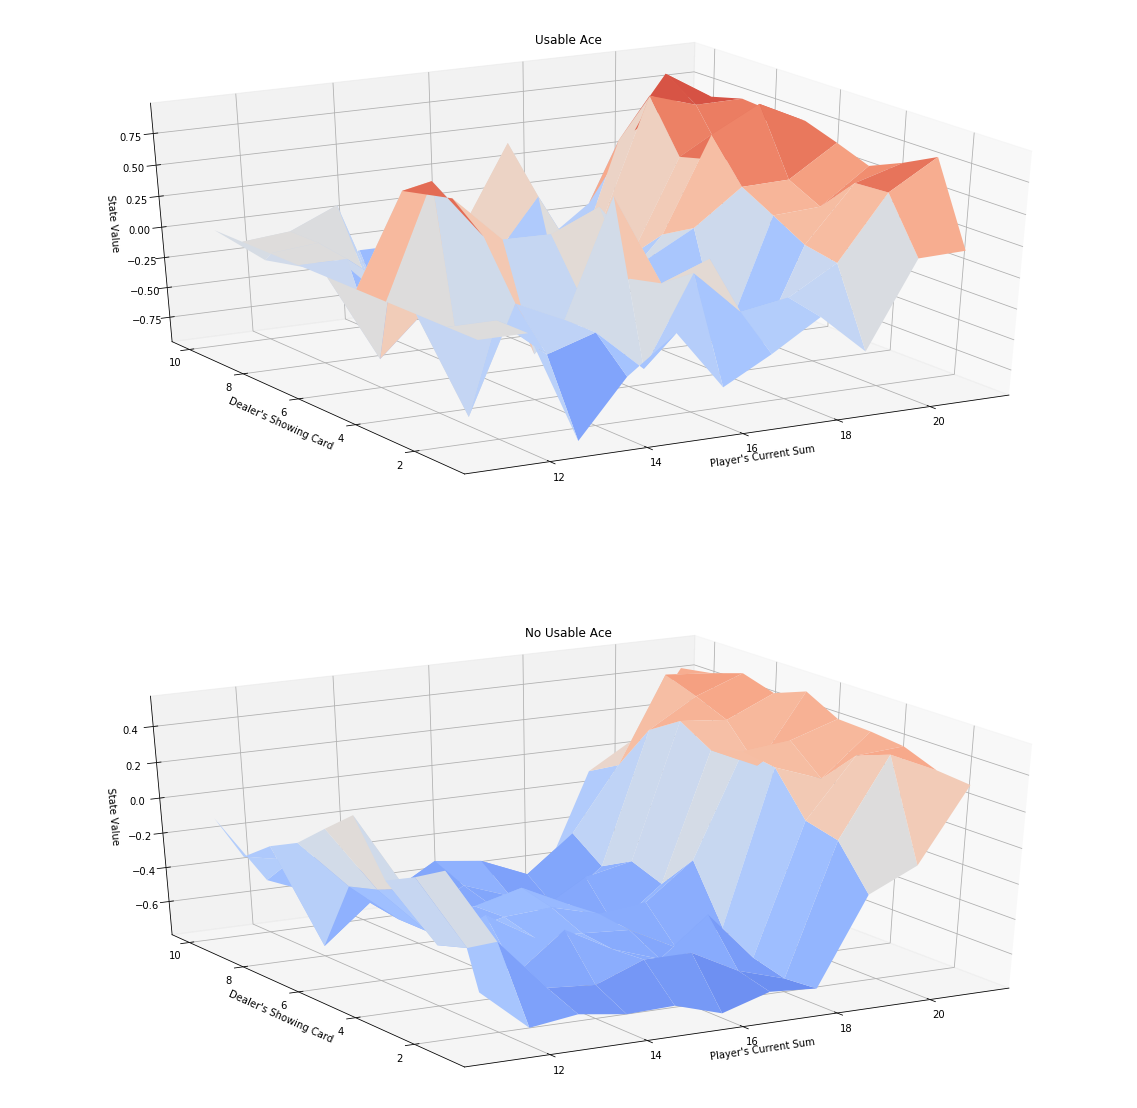

In [83]:
# obtain the action-value function
gamma = 0.9
Q = mc_prediction_q(env, 5000, generate_episode_from_limit_stochastic, gamma)

# obtain the corresponding state-value function under policy Pi
# V[Pi](s) = P[Pi](a0) * Q(s, a0) + P[Pi](a1) * Q(s, a1)
# elements in V_to_plot like (15, 3, False): -0.8
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

### Part 2: MC Control

In this section, you will write your own implementation of constant-$\alpha$ MC control.  

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.
- `policy`: This is a dictionary where `policy[s]` returns the action that the agent chooses after observing state `s`.

(_Feel free to define additional functions to help you to organize your code._)

In [86]:
def generate_episode(env, policy):
    state = env.reset()
    episode = []
    while True:
        logger_3.info('state = {}'.format(state))
        action = policy[state]
        logger_3.info('action from policy = {}'.format(action))
        next_state, reward, done, info = env.step(action)
        logger_3.info('done = {}'.format(done))
        if not done:
#             print("NOT DONE")
            logger_3.info('next_state = {}'.format(next_state))
        else: logger_3.info('reward = {}'.format(reward))
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode  # [((11, 4, False), 1, 0), ((21, 4, False), 0, 0.0)]

def update_policy(policy, Q, epsilon, nA):
    for state in policy.keys():
        logger_3.info('state in policy.keys() = {}'.format(state))
        best_action_id = np.argmax(Q[state])
        logger_3.info('best_action_id = {}'.format(best_action_id))
        action_probs = (epsilon / 2) * np.ones(nA)
        action_probs[best_action_id] += (1 - epsilon)
        logger_3.info('action_probs = {}'.format(action_probs))
        action_id = np.random.choice(np.arange(nA), 1, p=action_probs)[0]
        logger_3.info('action_id = {}'.format(action_id))
        policy[state] = action_id
    return policy

def update_Q(Q, episode, alpha, gamma):
    states, actions, rewards = zip(*episode)
    logger_3.info('episode = {}'.format(episode))
    logger_3.info('states = {}'.format(states))
    visited_states = []
    discout_factor = [gamma ** i for i in range(len(states) + 1)]
    for i, state in enumerate(states):
        if state in visited_states:
            logger_3.info('ignore state = {}'.format(state))
        else:
            g = sum([rewards[j] * discout_factor[j] for j in range(i, len(states)) ])
            delta = Q[state][action] - g
            Q[state][action] = (1-alpha) * Q[state][action] + alpha * delta
    return Q

def mc_control(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize (arbitrarily) empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    policy = defaultdict(int)
    logger_3.info('init policy = {}'.format(policy))

#     policy = {}
    epsilon_schedule = np.linspace(0.9, 0.1, num_episodes + 1)
    logger_3.info('epsilon_schedule = {}'.format(epsilon_schedule))

    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        epsilon = epsilon_schedule[i_episode]
        # policy improvement (epsilon-greedy)
        policy = update_policy(policy, Q, epsilon, nA)     
        
        # generate episode
        episode = generate_episode(env, policy)
        logger_3.info('episode = {}'.format(episode))

        # policy evaluation (update Q)
        Q = update_Q(Q, episode, alpha, gamma)
        
    return policy, Q

Use the cell below to obtain the estimated optimal policy and action-value function.  Note that you should fill in your own values for the `num_episodes` and `alpha` parameters.

In [87]:
# obtain the estimated optimal policy and action-value function
num_episodes = 10000
alpha = 0.5
gamma = 0.9
policy, Q = mc_control(env, num_episodes, alpha, gamma)

Episode 10000/10000.

Next, we plot the corresponding state-value function.

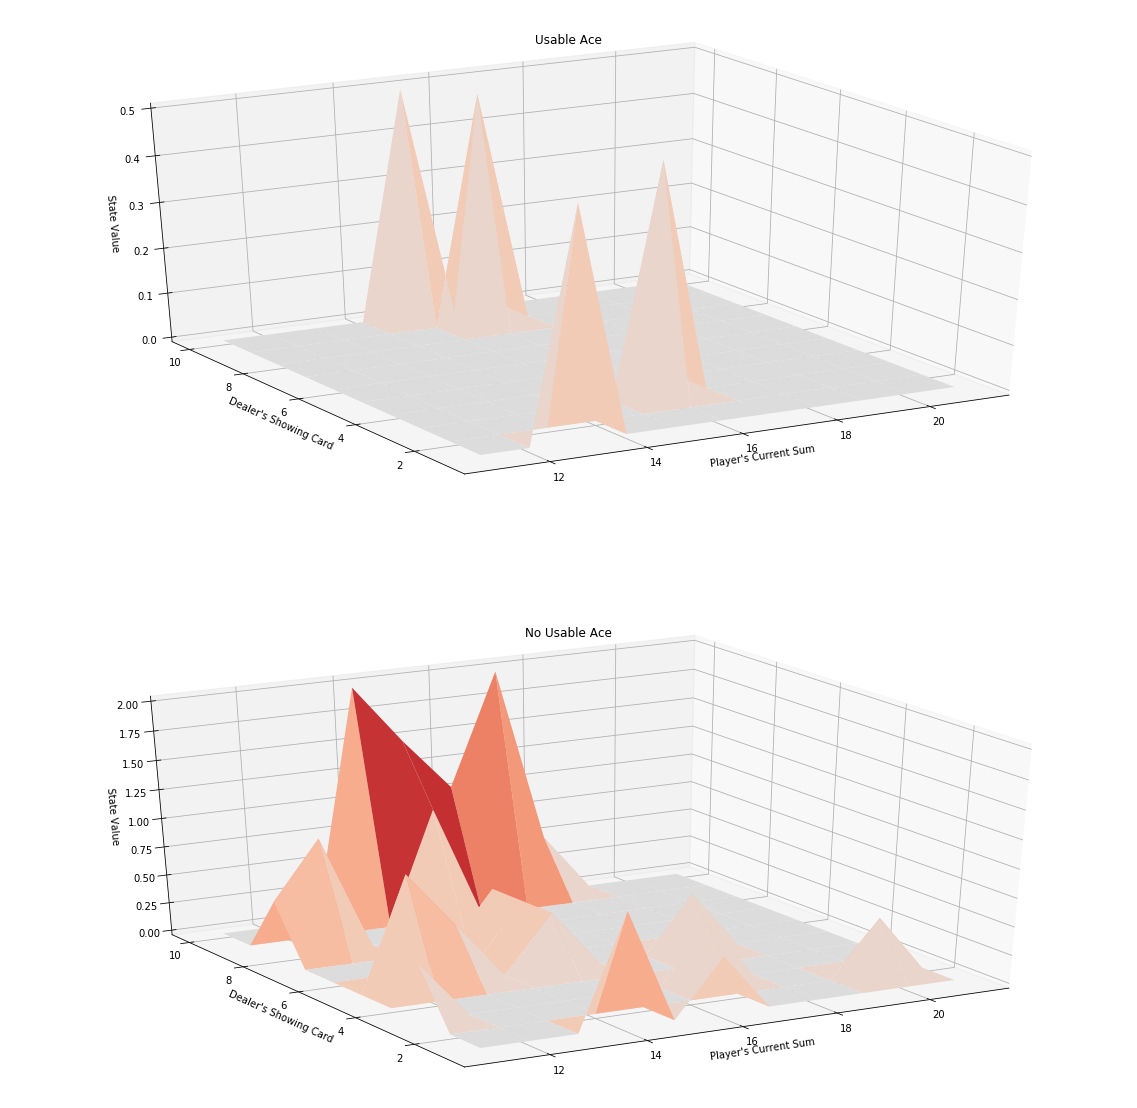

In [79]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

Finally, we visualize the policy that is estimated to be optimal.

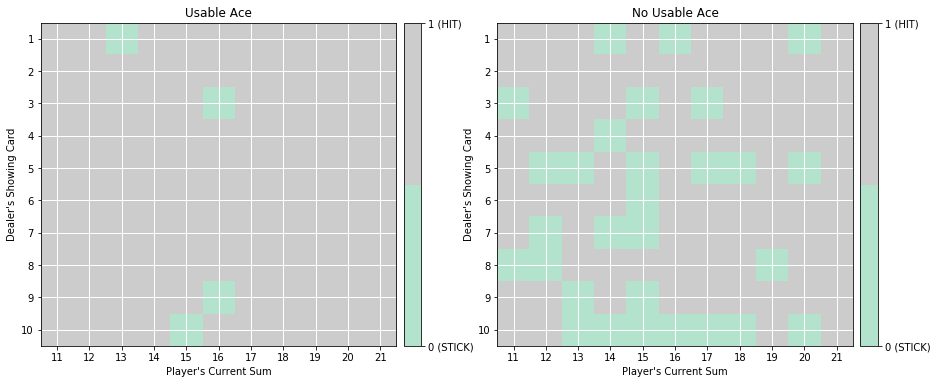

In [80]:
# plot the policy
plot_policy(policy)

The **true** optimal policy $\pi_*$ can be found in Figure 5.2 of the [textbook](http://go.udacity.com/rl-textbook) (and appears below).  Compare your final estimate to the optimal policy - how close are you able to get?  If you are not happy with the performance of your algorithm, take the time to tweak the decay rate of $\epsilon$, change the value of $\alpha$, and/or run the algorithm for more episodes to attain better results.

![True Optimal Policy](images/optimal.png)